In [35]:
# define relevants paths and load functions and libraries

%run Bianchini2025_SC\\Analysis\\helper_functions\\functions_analysis.py
    
data_path = 'Bianchini2025_SC\\Datasets\\' # your data path
saving_path = 'Bianchini2025_SC\\Figures_output\\' # your saving figures path

In [2]:
# import relevant datasets

# load the main dataset
file= ''.join([data_path,'neurons_datasets\\delay_tuning_dataset.mat'])
data_dict = mat73.loadmat(file)
DAT=data_dict['merged_dataset']

# check keys available
print(DAT.keys())

# extract all keys
for k in DAT.keys():
    globals()[k] = DAT[k]

dict_keys(['AP_lim', 'ML_lim', 'all_boot_aud', 'all_boot_vis', 'animal_ID', 'binSize', 'coord3D', 'depth_lim', 'experiment_ID', 'modality', 'peaks', 'pvals', 'resp', 'spikes', 'trials', 'window_spikes'])


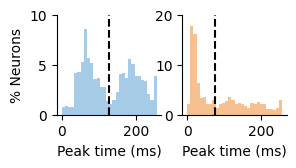

In [3]:
# Plot visual and auditory latencies - Fig 2A

#load the latenices
load_dir = ''.join([data_path,'neurons_datasets\\latencies_vis_aud.npy'])
latencies = np.load(load_dir)

dims = (1, 2)
fig, axs = plt.subplots(*dims, figsize=(2.3,1))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

this_ax = axs[0]
sns.histplot(latencies[modality==1,0], stat='percent',bins = 30, edgecolor="black", linewidth=0,color='#4D98CE',alpha=0.5,ax=this_ax)
this_ax.set_ylabel('')
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)
this_ax.set_ylabel('% Neurons',fontsize=10)

bar_heights_percent = [p.get_height() for p in this_ax.patches]

# Convert percentage heights back to counts
total_points = len(latencies[modality==1,0])
bin_counts = [height * total_points / 100 for height in bar_heights_percent]

# Get the maximum bin count
max_bin_count = max(bin_counts)

# Convert the upper limit to percentage
ratio = 0.1  # Change this ratio according to your preference
upper_limit_count = max_bin_count + ratio * max_bin_count
upper_limit_percent = np.round(upper_limit_count / total_points * 100)
# Set the y-axis limit
this_ax.set_ylim(0, upper_limit_percent)
#this_ax.set_xticks([])
this_ax.axvline(x=128, color='k', linestyle='--')
this_ax.set_xlabel('Peak time (ms)',fontsize=10)
this_ax.set_yticks([0,5,10])

this_ax = axs[1]
sns.histplot(latencies[modality==2,1], stat='percent',bins = 30, edgecolor="black", linewidth=0,color='#EE8222',alpha=0.5,ax=this_ax)
this_ax.set_xlabel('Peak time (ms)',fontsize=10)
this_ax.set_ylabel('')
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)

bar_heights_percent = [p.get_height() for p in this_ax.patches]
# Convert percentage heights back to counts
total_points = len(latencies[modality==2,1])
bin_counts = [height * total_points / 100 for height in bar_heights_percent]
# Get the maximum bin count
max_bin_count = max(bin_counts)
# Convert the upper limit to percentage
ratio = 0.1  # Change this ratio according to your preference
upper_limit_count = max_bin_count + ratio * max_bin_count
upper_limit_percent2 = np.round(upper_limit_count / total_points * 100)
# Set the y-axis limit
this_ax.set_ylim(0, 20)
this_ax.axvline(x=76, color='k', linestyle='--')

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2A.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)

In [5]:
# run hierarchical bootstrap to test for differences between visual and auditory latency

vis_latency = latencies[modality==1,0]
aud_latency = latencies[modality==2,1]

vis_animals = animal_ID[modality==1]
vis_experiments = experiment_ID[modality==1]
aud_animals = animal_ID[modality==2]
aud_experiments = experiment_ID[modality==2]

# Combine into DataFrames
df_vis = pd.DataFrame({
    'latency': vis_latency,
    'animal': vis_animals,
    'experiment': vis_experiments
})

df_aud = pd.DataFrame({
    'latency': aud_latency,
    'animal': aud_animals,
    'experiment': aud_experiments
})


In [66]:
# Hierarchical bootstrap function
def hierarchical_sample_latency(df, rng):
    sampled_data = []
    unique_animals = df['animal'].unique()
    resampled_animals = rng.choice(unique_animals, size=len(unique_animals), replace=True)
    
    for animal in resampled_animals:
        df_animal = df[df['animal'] == animal]
        unique_exps = df_animal['experiment'].unique()
        resampled_exps = rng.choice(unique_exps, size=len(unique_exps), replace=True)
        
        for exp in resampled_exps:
            neurons = df_animal[df_animal['experiment'] == exp]['latency'].values
            if len(neurons) > 0:
                sampled_neurons = rng.choice(neurons, size=len(neurons), replace=True)
                sampled_data.extend(sampled_neurons)
    
    return np.array(sampled_data)

In [6]:
# Get distribution of bootstrap

n_bootstrap = 1000
boot_diffs = []

rng = np.random.default_rng(seed=42)  # Set seed for reproducibility

for _ in range(n_bootstrap):
    vis_sample = hierarchical_sample_latency(df_vis, rng)
    aud_sample = hierarchical_sample_latency(df_aud, rng)
    
    vis_med = np.median(vis_sample)
    aud_med = np.median(aud_sample)
    
    boot_diffs.append(vis_med - aud_med)
    
boot_diffs = np.array(boot_diffs)
boot_diffs = boot_diffs[~np.isnan(boot_diffs)]  # Drop NaNs

# Calculate percentile of zero
target_value = 0
percentile = stats.percentileofscore(boot_diffs, target_value, kind='rank')
quantile = percentile / 100
p = 2 * np.minimum(quantile, 1 - quantile)

# Print results
print(f"Bootstrap median difference (vis - aud): {np.median(boot_diffs):.2f} ms")
print(f"Two-tailed p-value: {p:.4f}")

Bootstrap median difference (vis - aud): 70.00 ms
Two-tailed p-value: 0.0060


In [7]:
# Plot spatial distribution of delay neurons - Fig 2C

#1 first identify delay neurons

sig_del = []
which_tr = []
for i in range(peaks.shape[0]):
    y = peaks[i,:-2]

    vis_FR = peaks[i,-2]
    aud_FR = peaks[i,-1]

    if vis_FR>aud_FR:
        boot_out = all_boot_vis[i,:]
    elif aud_FR>vis_FR:
        boot_out = all_boot_aud[i,:]
    
    pos_sig = np.argwhere(boot_out>0)
    
    if len(pos_sig)>0:
        sig_del.append(i)
        tr = pos_sig[np.argmax(y[pos_sig])]
        which_tr.append(tr) 

sig_del = np.array(sig_del)
pref_delay=np.array(which_tr)[:,0]

In [8]:
#2- load the the atlas SC images

dir1=file=''.join([data_path,'SC_AP_modified.tif'])
im_AP = imageio.imread(dir1)
img = Image.open(dir1)

dir2=file=''.join([data_path,'SC_ML_modified.tif'])
im_ML = imageio.imread(dir2)

im_AP=img.resize((im_AP.shape[0],im_ML.shape[0]))

# normalize 3D coordinates
 
coord3D_lab=['AP','depth_in_brain','ML']
#normalize values
ML_norm = ((coord3D[:,2] - ML_lim[0]) / (ML_lim[1] - ML_lim[0]))*im_ML.shape[1]
AP_norm = ((coord3D[:,0] - AP_lim[0]) / (AP_lim[1] - AP_lim[0]))*(673)+20
depth_norm = ((coord3D[:,1] -depth_lim[0]) / (depth_lim[1] - depth_lim[0]))*im_ML.shape[0]

coord3D_norm= np.transpose(np.array([ML_norm,AP_norm,depth_norm]))

# invert the ML axis first
max_val = im_ML.shape[1]
min_val = 0 
new_ML = np.array([max_val - val + min_val for val in ML_norm])
ML_norm = new_ML


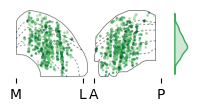

In [11]:
#3- plot the spatial distribution of delay neurons

n_colors = 15
n_delays = 11
colors = sns.color_palette('Greens', n_colors=n_colors)#YlGn'
selected_colors = colors[n_colors-n_delays:]
delay_cmap = ListedColormap(selected_colors)

sig_del #these are my delay neurons
color = selected_colors[5]

dims = (1,3)
fig, axs = plt.subplots(*dims, figsize=(2.5, 0.67), 
                        gridspec_kw={'width_ratios': [1, 1, 0.2], 
                                     'wspace': -0.3, 'hspace': 0.3}, 
                        subplot_kw={'aspect': 1})
# Adjust the figure margins to eliminate whitespace
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

# first we plot ML distribution 
this_ax = axs[0]

this_ax.set_anchor('E')
this_ax.scatter(ML_norm[sig_del],depth_norm[sig_del],alpha=.5, c=pref_delay,cmap=delay_cmap,s=1)  
this_ax.invert_yaxis()
this_ax.imshow(im_ML)#,aspect="auto")
this_ax.spines.right.set_visible(False)
this_ax.spines.top.set_visible(False)
#ax.margins(x=0.1, y=0.1)  # Increase the margins around the plot
this_ax.spines['left'].set_position(('outward', 1))  # Move the left spine outward
this_ax.spines['bottom'].set_position(('outward', 1))  # Move the bottom spine outward
# Remove the axis line
this_ax.spines.left.set_visible(False)
this_ax.spines.bottom.set_visible(False)
this_ax.set_xticks([0, len(im_ML)])
this_ax.set_yticks([])
this_ax.set_xticklabels(['M', 'L'])

# then we plot AP
this_ax = axs[1]
this_ax.scatter(AP_norm[sig_del],depth_norm[sig_del],alpha=.5,c=pref_delay,cmap=delay_cmap,s=1)
this_ax.invert_yaxis()
this_ax.imshow(im_AP)   
this_ax.spines.right.set_visible(False)
this_ax.spines.top.set_visible(False)
this_ax.spines['left'].set_position(('outward', 1))  # Move the left spine outward
this_ax.spines['bottom'].set_position(('outward', 1))  # Move the bottom spine outward

# Remove the axis line
this_ax.spines.left.set_visible(False)
this_ax.spines.bottom.set_visible(False)
this_ax.set_xticks([0, len(im_ML)])
this_ax.set_xticklabels(['A', 'P'])
this_ax.set_yticks([])

# then we plot the depth distribution
this_ax = axs[2]
sns.kdeplot(y=depth_norm[sig_del], color=color, fill=True, ax=this_ax)
this_ax.invert_yaxis()
this_ax.axis('off')
#this_ax.set_ylim([0, im_ML.shape[1]])
asp = np.diff(this_ax.get_xlim())[0] / np.diff(this_ax.get_ylim())[0]
this_ax.set_aspect(-5*asp)
plt.draw()   
    
# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2C.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)

In [12]:
# Plot two examples delay neurons - Fig 2D

#1- for plotting example neurons you need to load also the raster and the psth
plot_examples = 1

if plot_examples == 1:
    # load the raster data
    file=''.join([data_path,'neurons_datasets\\raster_delay_tuning_dataset.mat'])
    data_dict = mat73.loadmat(file)
    raster=data_dict['raster']
    raster = raster['tr']

    # load the IFR data
    file=''.join([data_path,'neurons_datasets\\psth_delay_tuning_dataset.mat'])
    data_dict = mat73.loadmat(file)
    IFRs = data_dict['neuron_IFR']['mean']

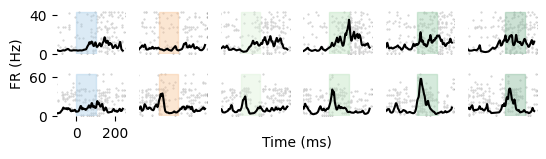

In [14]:
#2- example delay neurons 
#colormap
how_many = 15
n_delays = 11
colors = sns.color_palette('Greens', n_colors=how_many)#YlGn'
selected_colors = colors[how_many-n_delays:]
delay_selected = np.array([0,3,6,9])
# Manually specify additional colors
additional_colors = ['#4D98CE', '#EE8222'] # for vis and aud
selected_colors = [selected_colors[d] for d in delay_selected]
# Combine all colors
colors = additional_colors + selected_colors


# plot example responses to delays with the tuning curves
aud_vis,aud_mod = [2086,704]
ids=np.array([aud_vis,aud_mod])
# select the AV condition
delay_cond = np.array([11,12,0,3,6,9]) #plot delays 0ms, 30ms, 60ms 90ms 
n_stim=6


dims = (2, 6)
fig, axs = plt.subplots(*dims, figsize=(6, 1.33),gridspec_kw={'wspace': 0.2})
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

pos = np.arange(len(ids)*n_stim)
pos = pos.reshape(n_stim,-1)

stims = delay_cond

# determine the position of the psth
this_order = np.arange(0,6*2).reshape(2,6)

for i in range(len(ids)):

    actual = IFRs[ids[i]] # now this is shaped trials x time
    actual = np.reshape(actual,(-1,1000))  # Now this is shaped trials x time
    maxFR = np.nanmax(actual)
    raster_now = raster[ids[i]]

    for t in range(n_stim):
        this_ax = axs[i, t]
        x = raster_now['x'][stims[t]][1::3]
        y = raster_now['y'][stims[t]][1::3]
        this_ax.grid(False)
        this_ax.set_xlim([-0.1, 0.25])#[-0.3, 0.5] # here I set the time 
        this_ax.set_ylim([0, 53])
        
        start = 0 + (stims[t]*0.01)
        if stims[t] == 12 or stims[t] == 11:
            start = 0
        hight = 50
        this_ax.scatter(x, y, s=0.3, c='#A0A0A0')        
        this_color = colors[t]
        rect = Rectangle((start, 0), 0.1, hight, linewidth=1, edgecolor=this_color, facecolor=this_color, zorder=1,alpha=0.4)
        this_ax.add_patch(rect)
        this_ax.set_xticks([])
        this_ax.set_yticks([]) 
        
        # Remove the spines from the original subplot
        this_ax.spines[:].set_visible(False)
        
        # Ticks only for the first plot
        if t == 0 and i == len(ids)-1:
            this_ax.set_xticks([0, 0.2])
            this_ax.set_xticklabels(['0','200'],fontsize = 10)
        
        # Plot over the current plot
        this_ax2 = fig.add_subplot(2,6,this_order[i,t]+1)
        this_ax2.patch.set_alpha(0.5)
        # Remove the spines from the twinned axes
        this_ax2.spines[:].set_visible(False)
        
        this_ax2.plot(actual[stims[t], :], c='black')
        this_ax2.set_xlim([299, 1000]) #this goes from -250 to +250
        this_ax2.set_ylim([0, maxFR + 10])
              
        this_ax2.set_xticks([])
        this_ax2.set_yticks([])
        
        if t==0:
            this_ax2.set_yticks([0,np.round(maxFR,-1)])  
            this_ax2.set_yticklabels([0,int(np.round(maxFR,-1))],fontsize = 10)

this_ax3 = fig.add_subplot(111)
this_ax3.patch.set_alpha(0)
this_ax3.spines[:].set_visible(False)
this_ax3.set_yticks([])
this_ax3.set_xticks([])
this_ax3.set_ylabel('FR (Hz)',labelpad=20,fontsize = 10)
this_ax3.set_xlabel('Time (ms)', labelpad=10,fontsize = 10)

fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2D.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)

In [15]:
# Plot tuning curve of the two examples delay neurons - Fig 2E

# since we want some confidence intervals we resample subsets of trials
# 1- smooth the spike trains

# Define the standard deviation for the Gaussian filter
sigma = 1.5

# Apply the Gaussian filter along the third axis
spikes_smooth = gaussian_filter1d(spikes, sigma, axis=2) #axis 2 is time

# 2- extract mean peak FR for 10 x 5 trials 
n_rep=50
n_stim= 13
length_window = 25
stim_onset=98 # -20 ms
stim_off=stim_onset+length_window # 250 ms

spikes_cut = spikes_smooth[:,:,stim_onset:stim_off]
spikes_cut_reshape = spikes_cut.reshape(spikes.shape[0],n_stim,n_rep,stim_off-stim_onset) 

binSize = 0.1
n_split = 5
n_neurons = spikes_cut_reshape.shape[0]

peaks_means = np.zeros((n_neurons,n_split,n_stim))
split_pos = np.arange(0,n_rep,10)

for n in range(n_neurons): # random order of trial for each neuron
    
    pos = np.array(random.sample(list(np.arange(n_rep)),n_rep)).reshape(-1)    
    this_neuron_spikes = spikes_cut_reshape[n,:,:,:]
    
    # find the peakFR
    mean_spikes = np.mean(this_neuron_spikes[:,:,:],axis=1)
    max_pos = np.argmax(mean_spikes,axis=1)             
        
    for s in range(n_split):
        
        if s == n_split-1:
            these_trials = pos[split_pos[s]:]
        else:
            these_trials = pos[split_pos[s]:split_pos[s+1]]
            
        this_spikes = np.mean(this_neuron_spikes[:,these_trials,:],axis = 1)                    
        
        for r in range(this_spikes.shape[0]):
            peaks_means[n,s,r] = np.mean(this_spikes[r,max_pos[r]-2:max_pos[r]+3])/binSize
            

C:\Users\bianchg\Miniconda3\envs\master\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
#3- normalize them all together 
my_array = peaks_means.reshape(peaks_means.shape[0],-1)

# choose the type of normalisation
norm = 1

if norm == 1: # z-score
    scaler = StandardScaler()
    normalized_array = scaler.fit_transform(my_array.T).T
else: # norm by the max
    normalized_array = (my_array - np.min(my_array, axis=1, keepdims=True)) / (np.max(my_array, axis=1, keepdims=True) - np.min(my_array, axis=1, keepdims=True))

# put it in the right shape
normalized_array = np.reshape(normalized_array,(peaks_means.shape[0],peaks_means.shape[1],peaks_means.shape[2]))


C:\Users\bianchg\Miniconda3\envs\master\lib\site-packages\sklearn\utils\extmath.py:981: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\bianchg\Miniconda3\envs\master\lib\site-packages\sklearn\utils\extmath.py:986: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\bianchg\Miniconda3\envs\master\lib\site-packages\sklearn\utils\extmath.py:1006: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


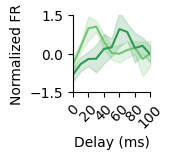

In [17]:
# after selecting them plot tuning curve of these neurons

how_many = 15
n_delays = 11
colors = sns.color_palette('Greens', n_colors=how_many)
selected_colors = colors[how_many-n_delays:]

disp_uni = 0
ids=np.array([aud_vis,aud_mod])
dims=(1,1)
fig, ax = plt.subplots(*dims, figsize=(1, 1))

this_ax = ax
colors =  selected_colors[3],selected_colors[6]
norm = 0

for i in range(len(ids)):
    curr_peaks = np.squeeze(normalized_array[ids[i],:,:])
    mean_curr_peaks = np.mean(curr_peaks,axis=0)
    sem_peaks = stats.sem(curr_peaks,axis=0)

    score_final_low = mean_curr_peaks[:-2]-sem_peaks[:-2]
    score_final_high = mean_curr_peaks[:-2]+sem_peaks[:-2]
    max_uni = np.max(mean_curr_peaks[-2:])
    max_multi = np.max(mean_curr_peaks[:-2])

    if norm ==1:
        curr_peaks = (curr_peaks-max_uni)/(max_multi-max_uni)
    
    this_ax.plot(mean_curr_peaks[:-2],c=colors[i]) 
    this_ax.fill_between(np.arange(len(mean_curr_peaks[:-2])),score_final_low,score_final_high,color=colors[i],alpha=0.2)
    
    if disp_uni == 1:
        # also add the mean FR for visual and auditory trials
        if mean_curr_peaks[11] > mean_curr_peaks[12]:
            this_ax.plot(x_values,np.full_like(x_values, mean_curr_peaks[11]),linestyle='--', color='k')
            print('ciao')
        else:
            this_ax.plot(x_values,np.full_like(x_values, mean_curr_peaks[12]),linestyle='--', color='k')
            print('ciao2')
    
x_positions = np.arange(0,mean_curr_peaks[:-2].shape[0],2)
this_ax.set_xlim([0,10])
x_labels = [0,20,40,60,80,100]#,60,70,80,90,100]
this_ax.set_xticks(x_positions, x_labels,fontsize=10,rotation=45)   # Set text labels and properties.
this_ax.set_ylabel('Normalized FR',fontsize=10)
this_ax.set_xlabel('Delay (ms)',fontsize=10)
this_ax.set_ylim([-1.5,1.5])
this_ax.set_yticks([-1.5,0,1.5],fontsize=10)
#this_ax.set_title('Tuning curve')
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2E.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


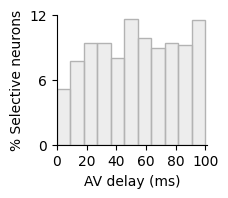

In [18]:
# Plot distribution of preferred delays for delay neurons - Fig 2F

dims = (1, 1)
fig, axs = plt.subplots(*dims, figsize=(1.5, 1.3))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5) 
this_ax = axs
arr = np.arange(0, 11) * 10
# Convert the array from an integer type to a string type
arr_str = [0,20,40,60,80,100]#arr.astype(str)
sns.histplot(pref_delay, bins = np.unique(pref_delay).shape[0],stat='percent',edgecolor='#b3b3b3', linewidth=1,color='gainsboro',alpha=0.5,ax=this_ax)

this_ax.set_xticks(np.arange(0, 11,2), arr_str,fontsize=10)#,rotation=45)
this_ax.set_xlabel('AV delay (ms)',fontsize=10)
this_ax.set_ylabel('% Selective neurons',fontsize=10)
this_ax.set_ylim([0,12])
this_ax.set_xlim([0,10.1])
this_ax.set_yticks([0, 6,12], fontsize=10)
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2F.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


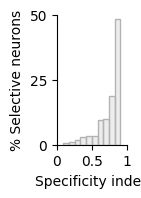

In [49]:
# Plot distribution of specifcity index for delay neurons - Fig 2G

# assess selectivity to specific delay as number of delay trials different from unisensory 
dims = (1, 1)
fig, this_ax = plt.subplots(*dims, figsize=(0.7, 1.3))
# Adjust the figure margins to eliminate whitespace
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5) 
how_many=[]
for i in range(peaks.shape[0]):
    
    vis_FR = peaks[i,-2]
    aud_FR = peaks[i,-1]
    
    if vis_FR>aud_FR:
        boot_out = all_boot_vis[i,:]
    elif aud_FR>vis_FR:
        boot_out = all_boot_aud[i,:]
    
    pos_sig = np.argwhere(boot_out>0)
    
    if len(pos_sig)>0:
        how_many.append(np.sum(boot_out[boot_out>0]))
        
unique_categories, counts = np.unique(how_many, return_counts=True)
how_many = 1-(np.array(how_many)/11)
n_bins = len(unique_categories)

sns.histplot(how_many, bins = n_bins,stat='percent',edgecolor='#b3b3b3', linewidth=1,color='gainsboro',alpha=0.5,ax=this_ax)
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)
this_ax.set_xlabel('Specificity index',fontsize=10)
this_ax.set_ylabel('% Selective neurons',fontsize=10)

bar_heights_percent = [p.get_height() for p in this_ax.patches]

# Convert percentage heights back to counts
total_points = len(how_many)
bin_counts = [height * total_points / 100 for height in bar_heights_percent]

# Get the maximum bin count
max_bin_count = max(bin_counts)

# Convert the upper limit to percentage
ratio = 0.1  # Change this ratio according to your preference
upper_limit_count = max_bin_count + ratio * max_bin_count
upper_limit_percent = upper_limit_count / total_points * 100

# Set the y-axis limit
this_ax.set_ylim(0, 50)
this_ax.set_yticks([0,25,50])
this_ax.set_xticks([0,0.5,1])
this_ax.set_xlim([0,1])
this_ax.set_xticklabels(['0','0.5','1'])

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2G.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


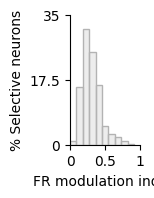

In [20]:
# Plot distribution of FR modulation index for delay neurons - Fig 2H

# assess selectivity to specific delay as deviation in FR
multi_peaks = peaks[:,:-2]    
DSI = []
for i in range(multi_peaks.shape[0]):
    DSI.append((np.nanmax(multi_peaks[i,:])-np.nanmin(multi_peaks[i,:]))/(np.nanmax(multi_peaks[i,:])+np.nanmin(multi_peaks[i,:])))
DSI = np.array(DSI)

dims = (1, 1)
fig, this_ax = plt.subplots(*dims, figsize=(0.7, 1.3))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

sig_DSI = DSI[sig_del]
sns.histplot(sig_DSI, bins = n_bins,stat='percent',edgecolor='#b3b3b3', linewidth=1,color='gainsboro',alpha=0.5,ax=this_ax)
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)
this_ax.set_xlabel('FR modulation index',fontsize=10)
this_ax.set_ylabel('% Selective neurons',fontsize=10)
this_ax.set_ylim([0,35])
this_ax.set_yticks([0,35/2,35])
this_ax.set_yticklabels([0,35/2,35])
this_ax.set_xticks([0,0.5,1])
this_ax.set_xlim([0,1])
this_ax.set_xticklabels(['0','0.5','1'])

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2H.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


In [21]:
# Plot distribution of realiability index for delay neurons - Fig 2I

# load the reliability of the responses to the preferred delay 
load_dir = ''.join([data_path,'neurons_datasets\\Inter_trial_variability_neurons.npy'])
final_corr = np.load(load_dir)
# and chance realiability
load_dir = ''.join([data_path,'neurons_datasets\\Inter_trial_variability_neurons_random.npy'])
final_corr_random = np.load(load_dir)

C:\Users\bianchg\AppData\Local\Temp\8\ipykernel_12936\3755742590.py:3: RuntimeWarning: All-NaN slice encountered
  mean_random = np.nanmedian(np.nanmedian(delay_neurons_corr_random,axis=1))


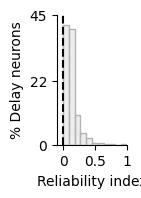

In [22]:
delay_neurons_corr = final_corr[sig_del, pref_delay]
delay_neurons_corr_random = final_corr_random[sig_del,:]
mean_random = np.nanmedian(np.nanmedian(delay_neurons_corr_random,axis=1))

# plot it
dims = (1, 1)
fig, this_ax = plt.subplots(*dims, figsize=(0.7, 1.3))
# Adjust the figure margins to eliminate whitespace
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5) 
n_bins = np.arange(12)/11

sns.histplot(delay_neurons_corr, bins = n_bins,stat='percent',edgecolor='#b3b3b3', linewidth=1,color='gainsboro',alpha=0.5,ax=this_ax)
this_ax.axvline(x=mean_random, color='k', linestyle='--')
this_ax.spines['top'].set_visible(False)
this_ax.spines['right'].set_visible(False)
this_ax.set_xlabel('Reliability index',fontsize=10)
this_ax.set_ylabel('% Delay neurons',fontsize=10)
this_ax.set_ylim([0,45])
y_ticks = np.array([0,45/2,45]).astype(int)
this_ax.set_yticks(y_ticks)
this_ax.set_xticks([0,0.5,1])
this_ax.set_xlim([-0.1,1])
this_ax.set_xticklabels(['0','0.5','1'])

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2I.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


In [51]:
# Save data to run LMM in matlab 
delay_neurons_corr = final_corr[sig_del, pref_delay]  # Subset correlation values
valid_indices = ~np.isnan(delay_neurons_corr)         # Filter out NaNs

# Filter data
pref_delay_mod = pref_delay[valid_indices]*10
reliability = delay_neurons_corr[valid_indices]
animal_mod = animal_ID[sig_del][valid_indices]
experiment_mod = experiment_ID[sig_del][valid_indices]
selectivity = how_many[valid_indices]
modulation_index = sig_DSI[valid_indices]

# Create DataFrame
df = pd.DataFrame({
    'pref_delay': pref_delay_mod,
    'reliability': reliability,
    'animal_ID': animal_mod,
    'experiment_ID': experiment_mod,
    'selectivity': selectivity,
    'modulation_index': modulation_index
})

# Save to CSV
df.to_csv(''.join([data_path,'neurons_datasets\\delay_neurons_properties.csv']), index=False)


0.8130495851916663


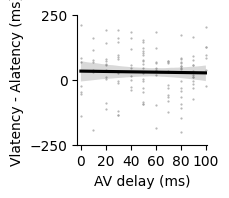

In [27]:
# Plot distribution of realiability index for delay neurons - Fig 2J

# the preferred delay was not predicted by the difference in the latency of the peak of the unisensory responses 
n_delays=11
vis_lat = latencies[:,0]
aud_lat = latencies[:,1]
diff_lat = vis_lat - aud_lat

dims = (1, 1)
fig, ax = plt.subplots(*dims, figsize=(1.3, 1.3))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)

this_ax = ax
AV_tuned_n = np.intersect1d(np.argwhere(modality==3),sig_del)
loc_instersect_AV = np.where(np.isin(sig_del, np.argwhere(modality==3)))[0]
sns.regplot(x=pref_delay[loc_instersect_AV], y=diff_lat[AV_tuned_n],scatter_kws={"color": '#A0A0A0','s':0.3}, line_kws={"color": 'black'},ax = this_ax)

this_ax.spines["right"].set_visible(False)
this_ax.spines['top'].set_visible(False)
this_ax.set_aspect('auto')
this_ax.set_xlabel('AV delay (ms)', fontsize = 10)
this_ax.set_ylabel('Vlatency - Alatency (ms)', fontsize = 10)
this_ax.set_xticks(np.arange(0,n_delays,2),np.arange(0,n_delays,2)*10, fontsize = 10)
this_ax.set_xlim([-0.3,10.1])
this_ax.set_ylim([-250,250])
this_ax.set_yticks([-250,0,250])

slope, intercept, r_value, p_value, std_err = stats.linregress(pref_delay[loc_instersect_AV],diff_lat[AV_tuned_n])
print(p_value)

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2J.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


In [28]:
# Plot schematic example of linear, non linear interactions  - Fig 2K
spikes = spikes.astype(float)
# get spikes and labels in the right shape 
all_spikes_sub_mean, all_labels = shift_sum_with_baseline(spikes,trials,sub_mean=1)

# reshape it in a two dimensional array 
all_spikes_reshaped = all_spikes_sub_mean.reshape(all_spikes_sub_mean.shape[0],-1)
all_spikes_reshaped = all_spikes_reshaped.reshape(all_spikes_sub_mean.shape[0], -1, 50, all_spikes_sub_mean.shape[2])

# Compute the mean along the second axis
mean_array = np.mean(all_spikes_reshaped, axis=2)
sem_array = stats.sem(all_spikes_reshaped, axis=2)

# let's plot examples of linear, sublinear and supralinear 
linear_neuron = 1570 #sig_del[170]
supra_neuron = 128 #sig_del[16]
sub_neuron = 1158 #sig_del[120]


its correct


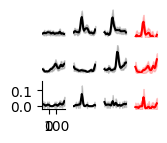

In [29]:
# Plot schematic example of linear, non linear interactions  - Fig 2K

sigma = 1

# Apply the Gaussian filter along the third axis
spikes_smooth = gaussian_filter1d(mean_array, sigma, axis=2) #axis 2 is time

ids=np.array([linear_neuron,supra_neuron,sub_neuron])
fig, axs = plt.subplots(3,4,figsize=(1.5, 1.3),#figsize=(8.3/2, 11.7/4),
                        gridspec_kw={'wspace': 0.3, 'hspace': 0.3}) 

for i in range(len(ids)):
    
    neuron_trace = np.squeeze(spikes_smooth[ids[i],:,:])
    sem_trace = np.squeeze(sem_array[ids[i],:,:])
    maxFR = np.max(np.concatenate([neuron_trace[0,:],neuron_trace[13,:]]))+0.1#+0.02
    
    ax0 = axs[i,0]
    ax0.plot(neuron_trace[11,:],c='k')
    score_final_low = neuron_trace[11,:] - sem_trace[11,:]
    score_final_high = neuron_trace[11,:] + sem_trace[11,:]
    ax0.fill_between(np.arange(neuron_trace[11,:].shape[0]),score_final_low,score_final_high,color='k',alpha=0.2)

    ax0.set_ylim([-0.02,maxFR])
    custom_xticks = [8,18]    
    ax0.set_xticks(custom_xticks)
    #ax0.set_xlim([stim_onset,stim_off])
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)
    
        
    ax1 = axs[i,1]
    
    ax1.plot(neuron_trace[12,:],c='k')
    score_final_low = neuron_trace[12,:] - sem_trace[12,:]
    score_final_high = neuron_trace[12,:] + sem_trace[12,:]
    ax1.fill_between(np.arange(neuron_trace[11,:].shape[0]),score_final_low,score_final_high,color='k',alpha=0.2)

    ax1.set_ylim([-0.02,maxFR])
    #ax1.set_xlim([stim_onset,stim_off])
    ax1.set_xticks(custom_xticks)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.axis('off')
    
    ax2 = axs[i,2]
    ax2.plot(neuron_trace[0,:],c='k')
    score_final_low = neuron_trace[0,:] - sem_trace[0,:]
    score_final_high = neuron_trace[0,:] + sem_trace[0,:]
    ax2.fill_between(np.arange(neuron_trace[11,:].shape[0]),score_final_low,score_final_high,color='k',alpha=0.2)
    #ax2.set_xlim([stim_onset-chosen_delay,stim_off-chosen_delay])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.axis('off')
    ax2.set_ylim([-0.02,maxFR])
    
    ax2 = axs[i,3]
    ax2.plot(neuron_trace[13,:],c='r')
    score_final_low = neuron_trace[13,:] - sem_trace[13,:]
    score_final_high = neuron_trace[13,:] + sem_trace[13,:]
    ax2.fill_between(np.arange(neuron_trace[11,:].shape[0]),score_final_low,score_final_high,color='r',alpha=0.2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.axis('off')
    ax2.set_ylim([-0.02,maxFR])
    


    if i == len(ids)-1:
        ax0.set_xticks(custom_xticks)
        ax0.set_xticklabels([0, 100])
    else:
        ax0.axis('off')

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2K.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


In [37]:
# Plot observed - predicted preferred delay  - Fig 2L

# calculate the sum 
all_spikes_sub_mean, all_labels = shift_sum(spikes,trials,sub_mean=1)

# reshape it in a two dimensional array 
all_spikes_reshaped = all_spikes_sub_mean.reshape(all_spikes_sub_mean.shape[0],-1)
all_spikes_reshaped = all_spikes_reshaped.reshape(all_spikes_sub_mean.shape[0], -1, 50, all_spikes_sub_mean.shape[2])

# Compute the mean along the second axis
mean_array = np.mean(all_spikes_reshaped, axis=2)

spikes_smooth = mean_array

n_neurons = spikes_smooth.shape[0]
binSize = 0.01

its correct


In [38]:
# find the peaks of the response
peaks_all = np.zeros((n_neurons,spikes_smooth.shape[1])) # N x T

for n in range(n_neurons): # random order of trial for each neuron 
    
    this_neuron_spikes = spikes_smooth[n,:,2:]    
    
    # find the peakFR
    max_pos = np.argmax(this_neuron_spikes,axis=1) 
    
    for r in range(this_neuron_spikes.shape[0]):
        peaks_all[n,r] = np.nanmean(this_neuron_spikes[r,max_pos[r]-1:max_pos[r]+2])/binSize


In [39]:
# now get the MII

MII_all = np.zeros((peaks_all.shape[0],peaks.shape[1]-2))
Adel_FR =[]
Asum_FR =[]
MII_all_old = np.zeros((peaks_all.shape[0],peaks.shape[1]-2))
for n in range(peaks_all.shape[0]):
    for d in range(11):
        del_FR = peaks_all[n,d]
        sum_FR = peaks_all[n,13+d]
        sum_FR_old = peaks_all[n,13-2]+peaks_all[n,13-1]

        if sum_FR <= 0 or del_FR <= 0:
            MII_all[n,d] = np.nan
            MII_all_old[n,d] = np.nan
        else:
            MII_all[n,d] = (del_FR - sum_FR)/sum_FR#(del_FR + sum_FR)#
            MII_all_old[n,d] = (del_FR - sum_FR_old)/sum_FR_old#(del_FR + sum_FR_old)
         
        Adel_FR.append(del_FR)
        Asum_FR.append(sum_FR)
        
print(np.nanmin(MII_all))
print(np.nanmax(MII_all))

-0.9500000000000001
1.152921504606847e+17


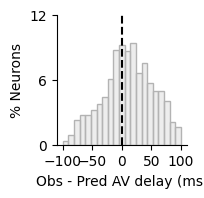

In [40]:
# find pref delay based on sum
sum_peaks = peaks_all[:,13:-1]
pref_del_sums = np.argmax(sum_peaks,axis=1)

# the preferred delay was not predicted by the linear summation of unisensory responses over time 
# what would be the pref delauy based on MII?
n_delays = 11

pred_pref_del = pref_del_sums[sig_del]

multi_peaks = peaks[:,:-2]  
pop_pref_delay = np.argmax(multi_peaks,axis=1)

dims = (1, 1)
fig, this_ax = plt.subplots(*dims, figsize=(1.3,1.3))
# Adjust the figure margins to eliminate whitespace
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5) 

difference = (pref_delay - pred_pref_del)*10
sns.histplot(difference, bins = np.unique(difference).shape[0],stat='percent',edgecolor='#b3b3b3', linewidth=1,color='gainsboro',alpha=0.5,ax=this_ax)

this_ax.spines["right"].set_visible(False)
this_ax.spines['top'].set_visible(False)
this_ax.set_xlabel('Obs - Pred AV delay (ms)', fontsize = 10)
this_ax.set_ylabel('% Neurons', fontsize = 10)
this_ax.set_xticks([-100,-50,-0,50,100], fontsize = 10)
plt.axvline(x=0, color='k', linestyle='--')
this_ax.set_ylim([0,12])
this_ax.set_yticks([0,6,12])

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2L.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)



In [41]:
# save it as a datafram to load in maltab for LMM

df_all = pd.DataFrame({
    'obs_delay': pref_delay*10,
    'pred_delay': pred_pref_del*10,
    'animal_ID': animal_ID[sig_del],
    'experiment_ID': experiment_ID[sig_del]
})

# Drop any rows with NaNs
df_all = df_all.dropna(subset=['obs_delay', 'pred_delay', 'animal_ID', 'experiment_ID'])

save_dir = ''.join([data_path,'neurons_datasets\\observed_vs_predicted_delay.csv'])
df_all.to_csv(save_dir, index=False)


In [42]:
# hierarchical bootstrap

rng = np.random.default_rng(seed=42)
boot_diffs = []

# Run bootstrap
for _ in range(n_bootstrap):
    obs_sample, pred_sample = hierarchical_paired_sample(df_all, rng)
    med_diff = np.median(obs_sample - pred_sample)
    boot_diffs.append(med_diff)

boot_diffs = np.array(boot_diffs)

# Compute p-value
target_value = 0
percentile = stats.percentileofscore(boot_diffs, target_value, kind='rank')
quantile = percentile / 100
p = 2 * min(quantile, 1 - quantile)

# Results
print(f"Median difference (observed - predicted): {np.median(boot_diffs):.2f} ms")
print(f"Two-tailed p-value from hierarchical paired bootstrap: {p:.10g}")

Median difference (observed - predicted): 10.00 ms
Two-tailed p-value from hierarchical paired bootstrap: 0.055


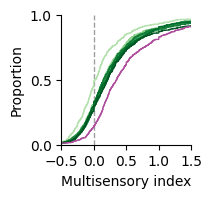

In [43]:
# Plot cumulative distribution MII for all delays  - Fig 2M

how_many = 15
n_delays = 11
colors = sns.color_palette('Greens', n_colors=how_many)
selected_colors = colors[how_many-n_delays:]

dims = (1, 1)
fig, this_ax = plt.subplots(*dims, figsize=(1.3, 1.3))
# Adjust the figure margins to eliminate whitespace
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5) 

this_ax.axvline(x=0, linestyle='--',color='#A0A0A0',linewidth=1)
which_data = np.squeeze(MII_all[sig_del,:])
for i in range(which_data.shape[1]):
    sns.ecdfplot(MII_all[sig_del,i],color=selected_colors[i],linewidth=1)
    
sns.ecdfplot(MII_all[sig_del,pref_delay],color='#AF4E9D',linewidth=1)
this_ax.spines["right"].set_visible(False)
this_ax.spines['top'].set_visible(False)
this_ax.set_ylabel('Proportion',fontsize = 10)
this_ax.set_xlabel('Multisensory index',fontsize = 10)
this_ax.set_xlim([-0.5,1.5])
this_ax.set_xticks([-0.5,0,0.5,1,1.5])
this_ax.set_yticks([0,0.5,1])

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2M.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)


In [44]:
# save data for LMM testing

MII_selected = MII_all[sig_del, :]  # shape (num_selected_neurons, num_delays)
animal_selected = animal_ID[sig_del]  # length num_selected_neurons
experiment_selected = experiment_ID[sig_del]  # length num_selected_neurons

n_delays = 11
n_delay_n = sig_del.shape[0]
neuron_ids = np.repeat(np.arange(n_delay_n), n_delays)         # each neuron repeated 11 times (for delays)
delays = np.tile(np.arange(1,n_delays+1), n_delay_n)            # delays repeated for all neurons
mii_values = MII_selected.flatten()                 # flatten all MII values

# Repeat animal and experiment IDs for each delay per neuron
animal_repeated = np.repeat(animal_selected, n_delays)   # repeat each animal_ID 11 times
experiment_repeated = np.repeat(experiment_selected, n_delays)

df_long = pd.DataFrame({
    'neuron_ID': neuron_ids,
    'delay': delays,
    'MII_value': mii_values,
    'animal_ID': animal_repeated,
    'experiment_ID': experiment_repeated
})

df_long = df_long.dropna(subset=['MII_value', 'delay', 'animal_ID', 'experiment_ID'])

df_long.to_csv(''.join([data_path,'neurons_datasets\\MII_data_for_lmm.csv']), index=False)


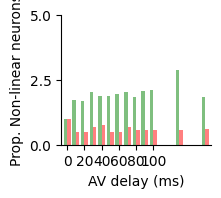

In [45]:
# Plot cumulative distribution MII for all delays  - Fig 2M

which_data = np.squeeze(MII_all[sig_del,:])
sup = []
sub = []
for d in range(which_data.shape[1]):

    sup.append((np.argwhere(which_data[:, d]>0.5).shape[0]/which_data[:, d].shape[0])*100)
    sub.append((np.argwhere(which_data[:, d]<-0.5).shape[0]/which_data[:, d].shape[0])*100)
# add some spacing
sup.append(0)
sub.append(0)
sup.append(0)
sub.append(0)

sup.append((np.argwhere(MII_all[sig_del,pref_delay]>0.5).shape[0]/MII_all[sig_del,pref_delay].shape[0])*100)
sub.append((np.argwhere(MII_all[sig_del,pref_delay]<-0.5).shape[0]/MII_all[sig_del,pref_delay].shape[0])*100)
# add some spacing
sup.append(0)
sub.append(0)
sup.append(0)
sub.append(0)

sup.append((np.argwhere(which_data.reshape(-1)>0.5).shape[0]/which_data.reshape(-1).shape[0])*100)
sub.append((np.argwhere(which_data.reshape(-1)<-0.5).shape[0]/which_data.reshape(-1).shape[0])*100)

dims = (1, 1)
fig, ax = plt.subplots(*dims, figsize=(1.5, 1.3))
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.subplots_adjust(hspace=0.5) 
x_vals = np.arange(len(sup))
width = 0.4  # Width of the bars

# Plotting the sup bars in green
ax.bar(x_vals - width/2, np.array(sup)/np.array(sup)[0], width=width, color='green',alpha = 0.5,label='Sup')
# Plotting the sub bars in red
ax.bar(x_vals + width/2, np.array(sub)/np.array(sub)[0], width=width, color='red',alpha = 0.5,label='Sub')

ax.spines["right"].set_visible(False)
ax.spines['top'].set_visible(False)
arr_str = [0,20,40,60,80,100]#arr.astype(str)
ax.set_xticks(np.arange(0, 11,2), arr_str,fontsize=10)#,rotation=30)
ax.set_xlabel('AV delay (ms)',fontsize=10)
ax.set_ylabel('Prop. Non-linear neurons',fontsize=10)
ax.set_ylim([0,5])
ax.set_xlim([-0.7,16.7])
ax.set_yticks([0, 2.5,5], fontsize=10)

# define a saving directory and save it 
dir = ''.join([saving_path,'Figure2N.svg'])
fig.savefig(dir, dpi=300,format='svg',bbox_inches='tight', pad_inches=0)
